Implementing Communication Waveforms
====================================

This Jupyter Notebook will highlight the development steps required to implement a new communication waveform within HermesPy.

Communication waveforms are the core configuration object of [Modem](../api/modem.modem.BaseModem.rst) operators.
They can be assigned to the [waveform](../api/modem.modem.BaseModem.rst#hermespy.modem.modem.BaseModem.waveform) slot and control the actual electromagnetic waveform transmitted and received by the modem, transmitting and receiving information in the form of binary bits.

Waveforms, by default, implement four complementary routines of the signal processing pipeline for communication, namely [modulation](../api/modem.waveform.rst#hermespy.modem.waveform.CommunicationWaveform.modulate), [demodulation](../api/modem.waveform.rst#hermespy.modem.waveform.CommunicationWaveform.demodulate),  [mapping](../api/modem.waveform.rst#hermespy.modem.waveform.CommunicationWaveform.map) and [unmapping](../api/modem.waveform.rst#hermespy.modem.waveform.CommunicationWaveform.unmap).
Mapping converts a sequence of communication bits to communication symbols on the complex plane during transmission, unmapping inverts this process by converting a communication symbols to a sequence of communication bits.
Modulation converts communcation symbols to base-band time-domain representations of waveforms to be transmitted, demodulation converts received base-band time-domain waveforms back to complex communication symbols.
Additionally, waveforms may implement routines for synchronization and equalization, but for the sake of simplicity the implementation of these routines will be skipped in this tutorial.

The waveform we will implement is a amplitude shift keying (ASK) modulation of variable modulation orders (number of modulation symbols). Initially, we will import all required Hermes classes:

In [1]:
import numpy as np

from hermespy.core import ConsoleMode, dB, Signal
from hermespy.modem import StatedSymbols, Symbols, CommunicationWaveform

[Signal](../api/core.signal_model.Signal.rst#hermespy.core.signal_model.Signal) is Hermes base class describing sampled MIMO signals in time-domain. [Symbols](../api/modem.symbols.rst#hermespy.modem.symbols.Symbols) is the signal model's equivalent on the demodulated symbol abstraction level, describing multiple streams of symbols in time-domain. The CommunicationWaveform represents, as already mentioned, the abstract base class of all communication waveforms. It features several abstract methods and properties to be implemented by the specific waveforms:

In [2]:
class AmplitudeShiftKeying(CommunicationWaveform):

    @property
    def samples_per_frame(self) -> int:

        return self.num_data_symbols * self.oversampling_factor

    @property
    def symbol_duration(self) -> float:
        return 1 / self.sampling_rate

    def bits_per_frame(self,num_data_symbols: int) -> int:

        return int(num_data_symbols * np.log2(self.modulation_order))

    @property
    def num_data_symbols(self) -> int:

        return 10

    @property
    def bit_energy(self) -> float:

        return 1. / np.log2(self.modulation_order)

    @property
    def symbol_energy(self) -> float:

        return 1.

    @property
    def power(self) -> float:

        return 1.

    @property
    def bandwidth(self) -> float:

        return 1.

    @property
    def sampling_rate(self) -> float:

        return 1.

    def map(self, data_bits: np.ndarray) -> Symbols:

        symbols_candidates = np.arange(1, 1 + self.modulation_order, dtype=complex) / (self.modulation_order)
        symbol_indices = np.packbits(data_bits.reshape((-1, int(np.log2(self.modulation_order)))), axis=1, bitorder='little').flatten()

        return Symbols(symbols_candidates[symbol_indices])

    def unmap(self, symbols: Symbols) -> np.ndarray:

        symbol_index_estimates = np.round(abs(symbols.raw.flatten()) * self.modulation_order - 1).astype(np.uint8)
        bits = np.unpackbits(symbol_index_estimates[:, np.newaxis], axis=1, bitorder='little')[:, :int(np.log2(self.modulation_order))]
        
        return bits.flatten()
    
    def place(self, symbols: Symbols) -> Symbols:
        
        return symbols
    
    def pick(self, symbols: StatedSymbols) -> StatedSymbols:
        
        return symbols

    def modulate(self, data_symbols: Symbols) -> np.ndarray:

        baseband_samples = np.repeat(data_symbols.raw.flatten(), self.oversampling_factor)
        return baseband_samples

    def demodulate(self, baseband_samples: np.ndarray) -> Symbols:
        
        symbols = Symbols(baseband_samples[::self.oversampling_factor])
        return symbols

This waveform implementation can already be assigned to a modem. Let's explain each implemented abstract function step by step:

*samples_in_frame* - indicates the number of required complex base-band samples at optimal sampling rate to demodulate a single frame generated by our waveform implementation.

*bits_per_frame* - indicates the number of data bits encoded within each communication frame.

*symbols_per_frame* - indicates the number of data symbols encoded within each communication frame. For convenience we have hard-coded $10$ symbols here.

*bit_energy* - average energy of a single bit.

*symbol_energy* - average energy of a single symbol. Since the PSK constellation is located on the complex unit circle, the energy is always one.

*symbol_power* - average power of a single symbol. Since the PSK constellation is located on the complex unit circle, the energy is always one.

*bandwidth* - bandwidth required to properly modulate and demodulate the waveform.

*sampling_rate* - sampling rate required to properly modulate and demodulate the waveform. For convenience we have chosen $1$ Hz. Of course this value is variable in practice.

We can now instantiate our newly defined communication waveform and inspect the mapping and modulation routines:

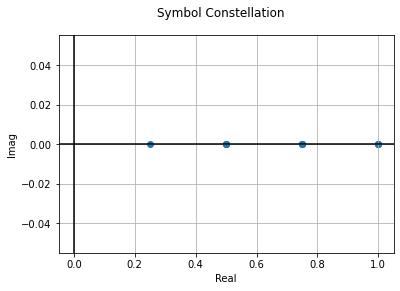

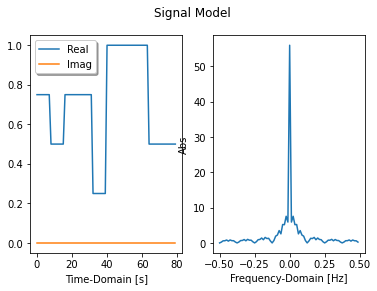

In [3]:
# Create pseudo-random number generator
rng = np.random.default_rng(42)

# Instantiante waveform
ask = AmplitudeShiftKeying(oversampling_factor=8, modulation_order=4)

# Generate a frame of data symbols from a set of random bits
data_bits = rng.integers(0, 2, ask.bits_per_frame(ask.num_data_symbols))
mapped_symbols = ask.map(data_bits)
_ = mapped_symbols.plot_constellation()

# Generate the base-band representation of a single communication frame
baseband_transmission = ask.modulate(ask.place(mapped_symbols))
_ = Signal.Create(baseband_transmission, ask.sampling_rate).plot()

We can now model the effects of hardware noise by adding a normally distributed noise signal to the baseband signal and observe the effects on the demodulated symbol constellation:

Transmitted data bits: [0 1 1 0 0 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0]
Received data bits: [0 1 1 0 0 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0]


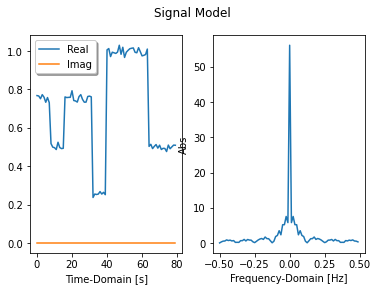

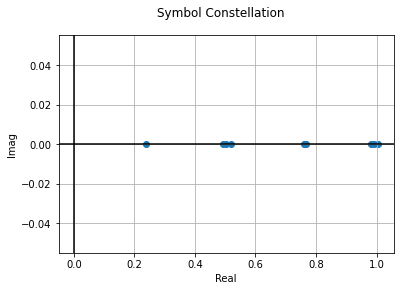

In [4]:
# Generate additive white gaussian noise
noise = rng.normal(0, .02, ask.samples_per_frame)

# Compute the baseband signal received over an AWGN channel
baseband_reception = baseband_transmission + noise
_ = Signal.Create(baseband_reception, ask.sampling_rate).plot()

# Demodulate the received signal
received_symbols = ask.demodulate(baseband_reception)
_ = received_symbols.plot_constellation()

bits = ask.unmap(received_symbols)
print(f'Transmitted data bits: {data_bits}')
print(f'Received data bits: {data_bits}')

Now, the newly added waveform is available to be configured to modems and used within the context of a simulation campaign:

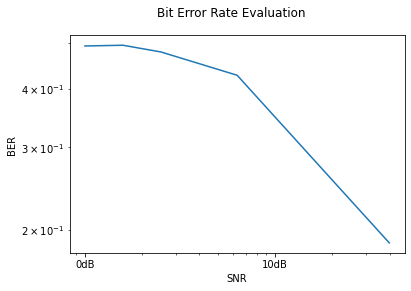

In [5]:
from hermespy.modem import BitErrorEvaluator, DuplexModem
from hermespy.simulation import Simulation

simulation = Simulation(console_mode=ConsoleMode.SILENT)

modem = DuplexModem()
modem.waveform = ask
modem.device = simulation.scenario.new_device()

simulation.new_dimension('noise_level', dB(0, 2, 4, 8, 16), modem.device)
simulation.add_evaluator(BitErrorEvaluator(modem, modem))
simulation.num_samples = 1000
result = simulation.run()
_ = result.plot()